In [7]:
# DATA GENERATOR

import os
import numpy as np

In [2]:

def load_image(img_dir,img_list):
    
    images=[]
    
    for i,image_name in enumerate(img_list):
        
        if (image_name.split('.')[1] =='npy'):
            
            image=np.load(img_dir+image_name).astype('float32') 
            
            images.append(image)
            
    images=np.array(images)
    return images

In [3]:
    
def image_loader(img_dir,img_list,mask_dir,mask_list,batch_size):
    
    L=len(img_list)
    
    while True :# Infinite due to Keras req
        
        batch_start=0
        batch_end=batch_size
        
        while batch_start<L:
            limit= min(batch_end,L)
            
            
            X=load_image(img_dir,img_list[batch_start:limit]).astype('float32') 
            Y=load_image(mask_dir,mask_list[batch_start:limit]).astype('float32') 
            
            
            yield(X,Y) #to return batch size
            
            batch_start += batch_size
            batch_end += batch_size
            

In [ ]:
import matplotlib.pyplot as plt
import random

train_img_dir='/kaggle/input/tumor-detection-in-pancreas/NPY_output_data/train/NPY_images/'
train_mask_dir='/kaggle/input/tumor-detection-in-pancreas/NPY_output_data/train/NPY_labels/'

train_img_list =sorted(os.listdir(train_img_dir))
train_mask_list =sorted(os.listdir(train_mask_dir))


 
batch_size=1

train_img_datagen=image_loader( train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)

#Verifying the Data generator

img ,msk = train_img_datagen.__next__()

In [ ]:

img_num = random.randint(0,img.shape[0]-1)

test_img = img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask,axis=3)

n_slice=random.randint(0,test_mask.shape[2])
plt.figure( figsize= (12,8))


plt.subplot(121)
plt.imshow(test_img[:,:,n_slice,0], cmap='gray')
plt.title("Image Flair")

plt.subplot(122)
plt.imshow(test_mask[:,:,n_slice])
plt.title("Mask")

plt.show()



In [ ]:

from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform'



def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))

    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    model.summary()
    
    return model


model = simple_unet_model(256,256,80,1,3)
print(model.input_shape)
print(model.output_shape)

In [ ]:
import keras

import glob
import random

In [ ]:

train_img_dir='/kaggle/input/tumor-detection-in-pancreas/NPY_output_data/train/NPY_images/'
train_mask_dir='/kaggle/input/tumor-detection-in-pancreas/NPY_output_data/train/NPY_labels/'

img_list=sorted(os.listdir(train_img_dir))
mask_list=sorted(os.listdir(train_mask_dir))


num_images=len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir + img_list[img_num]).astype('float32')  
test_mask = np.load(train_mask_dir + mask_list[img_num]).astype('float32')
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')

plt.subplot(222)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()


In [ ]:
'''
#Custom weight calculation 
import pandas as pd
columns = ['0','1', '2']
df = pd.DataFrame(columns=columns)
train_mask_list = sorted(glob.glob('/kaggle/input/tumor-detection-in-pancreas/NPY_output_data/train/NPY_labels/*.npy'))
for img in range(len(train_mask_list)):
    print(img)
    temp_image=np.load(train_mask_list[img]).astype('float32') 
    temp_image = np.argmax(temp_image, axis=3)
    val, counts = np.unique(temp_image, return_counts=True)
    zipped = zip(columns, counts)
    conts_dict = dict(zipped)
    
    df = df._append(conts_dict, ignore_index=True)

label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['2'].sum()

total_labels = label_0 + label_1 + label_2 
n_classes = 3

wt0 = round((total_labels/(n_classes*label_0)), 2) 
wt1 = round((total_labels/(n_classes*label_1)), 2)
wt2 = round((total_labels/(n_classes*label_2)), 2)

print("Weight are:",wt0 ,wt1 ,wt2)
'''

In [8]:

#Weight are: 0.34 37.15 167.42

train_img_dir='/kaggle/input/tumor-detection-in-pancreas/NPY_output_data/train/NPY_images/'
train_mask_dir='/kaggle/input/tumor-detection-in-pancreas/NPY_output_data/train/NPY_labels/'

val_img_dir='/kaggle/input/tumor-detection-in-pancreas/NPY_output_data/val/NPY_images/'
val_mask_dir='/kaggle/input/tumor-detection-in-pancreas/NPY_output_data/val/NPY_labels/'

train_img_list=sorted(os.listdir(train_img_dir))
train_mask_list=sorted(os.listdir(train_mask_dir))

val_img_list=sorted(os.listdir(val_img_dir))
val_mask_list=sorted(os.listdir(val_mask_dir))



batch_size = 2

train_img_datagen = image_loader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)

val_img_datagen = image_loader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

img, msk = train_img_datagen.__next__()


In [ ]:

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')

plt.subplot(222)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()


In [ ]:
!pip install segmentation_models_3D


In [ ]:
wt0 = 0.34
wt1 = 37.15 
wt2 = 167.42


import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim =keras.optimizers.Adam(LR)



steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size


In [ ]:

model = simple_unet_model(IMG_HEIGHT=256, 
                          IMG_WIDTH=256, 
                          IMG_DEPTH=80, 
                          IMG_CHANNELS=1, 
                          num_classes=3)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)




In [ ]:


history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=8,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

model.save('Pancreatic_Tumor_detection.hdf5')

In [ ]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
from keras.models import load_model

my_model = load_model('/kaggle/working/Pancreatic_Tumor_detection.hdf5', 
                      compile=False)
from keras.metrics import MeanIoU

batch_size=8 #Check IoU for a batch of images
test_img_datagen = image_loader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())








2024-07-25 21:31:27.799567: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=4,k3=0} for conv (f32[8,16,256,256,80]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[8,16,256,256,80]{4,3,2,1,0}, f32[16,16,3,3,3]{4,3,2,1,0}, f32[16]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-25 21:31:28.223502: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.424047706s
Trying algorithm eng11{k2=4,k3=0} for conv (f32[8,16,256,256,80]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[8,16,256,256,80]{4,3,2,1,0}, f32[16,16,3,3,3]{4,3,2,1,0}, f32[16]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","s

1/1 ━━━━━━━━━━━━━━━━━━━━ 82s 82s/step
Mean IoU = 0.3223442


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/tumor-detection-in-pancreas/NPY_output_data/val/NPY_images/image82.npy'

In [10]:
#############################################
#Predict on a few test images, one at a time
#Try images: 
img_num = 83

test_img = np.load("/kaggle/input/tumor-detection-in-pancreas/NPY_output_data/val/NPY_images/image"+str(img_num)+".npy")

test_mask = np.load("/kaggle/input/tumor-detection-in-pancreas/NPY_output_data/val/NPY_labels/mask"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))

2024-07-25 21:40:34.023565: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[1,16,256,256,80]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[1,32,256,256,80]{4,3,2,1,0}, f32[16,32,3,3,3]{4,3,2,1,0}, f32[16]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-25 21:40:34.969589: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.946247224s
Trying algorithm eng0{} for conv (f32[1,16,256,256,80]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[1,32,256,256,80]{4,3,2,1,0}, f32[16,32,3,3,3]{4,3,2,1,0}, f32[16]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


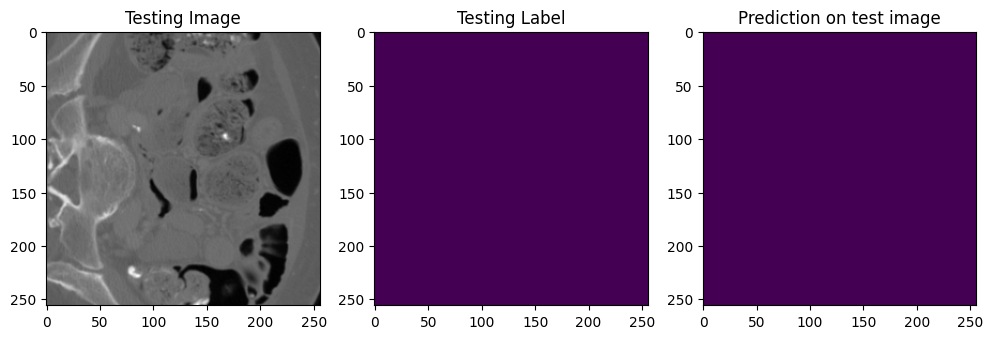

In [48]:
#Plot individual slices from test predictions for verification
import matplotlib.pyplot as plt
import random
n_slice=random.randint(0, test_prediction_argmax.shape[2])

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()
